## MICRONS Functional Data access

The MICRONS project collected a large scale functional imaging experiment from the mouse before it went through processing for electron microscopy. This notebook will teach you how to access that data and link it to the structural measurements in the electron microscopy portion of the dataset. 

The functional data is stored in a framework called DataJoint which is backed by MySql. [DataJoint](https://datajoint.org/) is a free, open-source framework for programming scientific databases and computational data pipelines that was developed by the Tolias Lab, and now as a for profit company. It should be pre-installed in your environment, and the json file 'dj_local_conf.json' in this folder contains the configuration about connecting to the server for you for the course. 

We will utilize a package called **nda** (neural data api) to connect to the DataJoint server. 

The **nda** package has a series of tables which provide information about the functional imaging experiment, including neural activity (masks and fluorescence traces), the stimulus, the animals behavior (running and pupil).  Ultimately the functional activity of individual regions of interest is stored in the "ScanUnit" table, which can then be linked to neurons in the electron microscopy dataset via the "functional_coreg" CAVE table, which contains primary keys of that table.

Outside of the course you must download this server and run it somewhere to access the data. Instructions for this can be found [here](https://github.com/cajal/microns-nda-access). Additional documentation about the functional data and links to technical information about the dataset are [here](https://github.com/cajal/microns_phase3_nda).

**to access these tables with datajoint you have to import nda, which is the primary functional data access module.**
func has some helper functions for you to use written on top of that.

The tables are summarized below

## nda table descriptions

### Imaging data structure

**nda.Scan:** Scans are collections of frames that were acquired simultaneously.  They are defined by a combination of session and scan index. Information on completed scans. Cajal Pipeline: [meso.ScanInfo](https://github.com/cajal/pipeline/blob/6a8342bf3edb07f5653c61024742258295cd8014/python/pipeline/meso.py#L29)

**nda.ScanInclude:** Scans determined suitable for analysis. Some scans did not complete successfully or had incomplete data, and so are not reccomended.

**nda.Field:** Individual fields of scans. Fields are single image planes. Each scans contains 8 fields. See [here](https://ngl.microns-explorer.org/#!gs://microns-static-links/mm3/all_fields_coreg.json) for a visualization of the scans to understand how the fields are distributed Cajal Pipeline: [meso.ScanInfo.Field](https://github.com/cajal/pipeline/blob/6a8342bf3edb07f5653c61024742258295cd8014/python/pipeline/meso.py#L54). On each frame of the scan, the microscope scanned one field, then hopped to the next field, and so on ina  loop. So the individual 8 frames are spread out across the inter-scan frame time. All 8 frames were imaged within the 6.3Hz acquisition rate.



### Functional extraction

**nda.Segmentation:** CNMF segmentation of a field using CaImAn package (https://github.com/simonsfoundation/CaImAn). It records the masks of all segmented cells. Mask_id's are unique per field. Cajal Pipeline: [meso.Segmentation.Mask](https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L765)

**nda.Fluorescence:** Records the raw fluorescence traces for each segmented mask. Cajal Pipeline: [meso.Fluorescence.Trace]. (https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L1159)

**nda.ScanUnit:** Unit_id assignment that is unique across the entire scan. Includes info about each unit. Cajal Pipeline: [meso.ScanSet.Unit / meso.ScanSet.UnitInfo](https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L1341)

**nda.Activity:** Deconvolved spike trace from the fluorescence trace. Cajal Pipeline: [meso.Activity.Trace](https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L1501)

**nda.MaskClassification:** Classification of segmented masks into soma or artifact. Uses CaImAn package (https://github.com/simonsfoundation/CaImAn). Cajal Pipeline: [meso.MaskClassification.Type](https://github.com/cajal/pipeline/blob/6f44fdbd186905d95a9a86d6d60ad147df24f9e2/python/pipeline/meso.py#L1478)

### Functional analysis

**nda.Oracle:** Measures how reliably each ScanUnit responds to visual stimulus Leave-one-out correlation for repeated videos in stimulus.

### Timing and stimulus

**nda.FrameTimes:** Timestamps of scan frames in seconds relative to the start of the scan for the first pixel of the first imaging field.  You can use this to get a precise timing of each unit in a consistent timebase.

**nda.Stimulus:** For each scan, contains the movie aligned to activity traces in `nda.Activity`. Note, this movie is now temporly downsampled to match the acquisition rate of the activity, but **does NOT reflect the temporal properties of the stimulus** that was actually shown to the animal. You have to download the actual stimulus movie at 30Hz if you want precise temporarily correct information about the pixels shown to the mouse during the scan. (see below)

**nda.Trial:** Contains information for each trial of the movie in `nda.Stimulus`. There are three types of trials, `Clip`, `Monet2`, and `Trippy`. Each unique trial has its own `condition_hash`. To get detailed information for each trial stimulus, join each `condition_hash` according to its corresponding type in one of: `nda.Clip`, `nda.Monet2`, or `nda.Trippy`.

**nda.Clip:** Detailed information for movie clips.

**nda.Monet2:** Detailed information for the Monet2 stimulus.

**nda.Trippy:** Detailed information for the Trippy stimulus.


### Behavior

**nda.RawManualPupil:** Pupil traces for each scan from the left eye collected at ~20 Hz and semi-automatically segmented. 

**nda.ManualPupil:** Manual pupil traces low-pass filtered with a hamming window to the scan frame rate and linearly interpolated to scan frame times.

**nda.RawTreadmill:** Cylindrical treadmill rostral-caudal position extracted with a rotary optical encoder at ~100Hz and converted into velocity.

**nda.Treadmill:** Treadmill velocities low-pass filtered with a hamming window to the scan frame rate then linearly interpolated to scan frame times.

### Co-registration

For most of your purposes, you can utilize the caveclient table 'functional_coreg' to find the ScanUnit information about neurons that have been coregistered, but if you are interested in diving into the details of the transformation, these tables are useful. 

**nda.MeanIntensity:** Mean intensity of imaging field over time. Cajal Pipeline: [meso.Quality.MeanIntensity](https://github.com/cajal/pipeline/blob/fa202ee43437a67d55719e8ae9769ee9937581d0/python/pipeline/meso.py#L173)

**nda.SummaryImages:** Reference images of the scan field. Cajal Pipeline: [meso.SummaryImages](https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L571)

**nda.Stack:** High-res anatomical stack information. Cajal Pipeline: [stack.CorrectedStack](https://github.com/cajal/pipeline/blob/6a8342bf3edb07f5653c61024742258295cd8014/python/pipeline/stack.py#L733)

**nda.Registration:** Parameters of the affine matrix learned for field registration into the stack. Cajal Pipeline: [stack.Registration.Affine](https://github.com/cajal/pipeline/blob/6a8342bf3edb07f5653c61024742258295cd8014/python/pipeline/stack.py#L1333)

**nda.Coregistration:** Coregistration transform solutions from the Allen Institute. [em_coregistration](https://github.com/AllenInstitute/em_coregistration/phase3)

**nda.StackUnit:** Unit coordinates in stack reference frame after field registration. `np_x, np_y, np_z` should be used for transformation to EM space using Coregistration. [meso.StackCoordinates.UnitInfo](https://github.com/cajal/pipeline/blob/921a920478c73687dd78b863fcd05e12bbf1e197/python/pipeline/meso.py#L1672)

**nda.AreaMembership:** Visual area labels for all units.



For more documentation see: [Cajal Pipeline Documentation](https://cajal.github.io/atlab-docs.github.io/pipeline.html)



In [18]:
%%capture
from phase3 import nda, func
import pandas as pd

## Table Diagram
The data from these tables are related in ways that allow you to perform certain manipulations, such as joining and merging. To help you see the relationships between these tables, the below graph represents tables as nodes and dependencies as directed edges between them.  The lines indicate which tables can be joined together, as they share foriegn keys. Datajoint's design is to make merges simple by enforcing strict structure on how column names should match across tables.

<img src="../resources/nda_erd.png"> 

## Basic DataJoint tutorial and data introduction

This tutorial will focus on basic DataJoint usage and introduce the functional data in the schema. 

For detailed information on the contents of the schema, please find our technical documentation [here](https://www.microns-explorer.org/cortical-mm3#f-data). 



### Scan table

Information from the completed scans are located in `nda.Scan`.

A scan represents one time the mouse was put under the microscope and imaging data was collected.

Each **session** happened on a single day, and **scan_idx** happened within those sessions.
***Note scan_idx is not unique**, so its the combination of **session** and **scan_idx** which is unique.

Access the table by calling:

In [19]:
nda.Scan()

session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
4,7,40000,8,6.3009
4,9,35112,8,6.3009
4,10,40000,8,6.3009
5,3,40000,8,6.3009
5,6,40000,8,6.3009
5,7,40000,8,6.3009
6,2,40000,8,6.3009
6,4,40000,8,6.3009
6,6,40000,8,6.3009
6,7,40000,8,6.3009


### Pandas conversion
You can convert these datajoint objects to dataframes by just declaring them as dataframes

In [20]:
pd.DataFrame(nda.Scan())

,session,scan_idx,nframes,nfields,fps
0,4,7,40000,8,6.30090
1,4,9,35112,8,6.30090
2,4,10,40000,8,6.30090
3,5,3,40000,8,6.30090
4,5,6,40000,8,6.30090
5,5,7,40000,8,6.30090
6,6,2,40000,8,6.30090
7,6,4,40000,8,6.30090
8,6,6,40000,8,6.30090
9,6,7,40000,8,6.30090


### Primary keys

[Primary](https://docs.datajoint.io/python/definition/07-Primary-Key.html?) keys are a subset of its attributes that uniquely identify each entity in the table.

In [21]:
[*nda.Scan.heading.primary_key] # primary keys 

['session', 'scan_idx']

### Restrict to a single scan

Dictionaries serve as keys for restricting table entries. Scans are indexed by `session` and `scan_idx`. The `session` attribute is the ID indicating the imaging period for the mouse. `scan_idx` is the index of the scan within the imaging session.

#### the '&' syntax
Using '&' with datajoint is like doing a filter on the table. 

The object on the right hand side of the merge must contain primary keys of the table on the left.

This can work with dictionaries you construct, assuming you name the columns to match the table you are filtering on.

For example, if we want to pull out a single scan, we can construct a dictionary with that Scan's primary key. 

In [22]:
scan_key = {'session': 4, 'scan_idx': 7} 

In [23]:
pd.DataFrame(nda.Scan & scan_key)

,session,scan_idx,nframes,nfields,fps
0,4,7,40000,8,6.3009


### Restrict to multiple scans

Use a list of dictionaries to restrict to multiple entries.

In [24]:
scan_keys = [{'session': 4, 'scan_idx': 7}, {'session': 5, 'scan_idx': 3}]

In [25]:
scan_res=pd.DataFrame(nda.Scan & scan_keys)
scan_res

,session,scan_idx,nframes,nfields,fps
0,4,7,40000,8,6.3009
1,5,3,40000,8,6.3009


### Fetch some information from a single scan

The [Fetch](https://docs.datajoint.io/python/queries/03-Fetch.html) methods allow for retrieval of the data within the tables. Use the `fetch1` method to retrieve the contents of the table for a single row. It will error if the restriction yields more than one row. 

In [26]:
nframes, nfields = (nda.Scan & scan_key).fetch1('nframes', 'nfields')
print(f'number of frames in this scan: {nframes}, number of imaging fields in this scan: {nfields}')

number of frames in this scan: 40000, number of imaging fields in this scan: 8


### Fetch some information from multiple scans

Use `fetch` if the restriction yields more than one row. It will return a list for each attribute that is fetched. To fetch all attributes, do not pass any attributes to the `fetch` method

In [27]:
nframes, nfields = (nda.Scan & scan_keys).fetch()
print(f'number of frames in these scans: {nframes}, number of fields in these scans: {nfields}')

number of frames in these scans: (4, 7, 40000, 8, 6.3009), number of fields in these scans: (5, 3, 40000, 8, 6.3009)


In [28]:
 (nda.Scan & scan_keys).fetch('nframes', 'nfields')

[array([40000, 40000], dtype=object), array([8, 8], dtype=object)]

### Fetch scans keys

Pass in `'KEY'` to `fetch` or `fetch1` to retrieve a list of dictionary keys.

In [29]:
pd.DataFrame(nda.Scan.fetch('KEY'))

,session,scan_idx
0,4,7
1,4,9
2,4,10
3,5,3
4,5,6
5,5,7
6,6,2
7,6,4
8,6,6
9,6,7


Fetch a single key.

In [30]:
(nda.Scan & scan_key).fetch1('KEY')

{'session': 4, 'scan_idx': 7}

### Included Scans

Scans designated for inclusion into analysis are found in `nda.ScanInclude`. Restrict against `nda.Scan` to apply.

In [31]:
# here '&' filters out Scans to only include those 
# that completed successfully
pd.DataFrame(nda.Scan & nda.ScanInclude)

,session,scan_idx,nframes,nfields,fps
0,4,7,40000,8,6.30090
1,5,6,40000,8,6.30090
2,5,7,40000,8,6.30090
3,6,2,40000,8,6.30090
4,6,4,40000,8,6.30090
5,6,6,40000,8,6.30090
6,6,7,40000,8,6.30090
7,7,3,40000,8,6.30090
8,7,4,40000,8,6.30090
9,7,5,40000,8,6.30090


### Field information

Each scan (identified by `session` and `scan_idx`) can have multiple imaging fields. These fields are indexed by the `field` attribute. `nda.Field` containes information for all imaging fields available for a scan.

In [32]:
# note that even though scan_key only has one entry
# there are multiple fields that match, so the filter
# returns all of them
nda.Field & scan_key

session Session ID,scan_idx Scan ID,field Field Number,px_width field pixels per line,px_height lines per field,um_width field width (microns),um_height field height (microns),field_x field x motor coordinates (microns),field_y field y motor coordinates (microns),field_z field z motor coordinates (microns)
4,7,1,248,440,620.0,1100.0,-485.0,-235.0,80.0
4,7,2,248,440,620.0,1100.0,95.0,-235.0,80.0
4,7,3,248,440,620.0,1100.0,-485.0,-235.0,220.0
4,7,4,248,440,620.0,1100.0,95.0,-235.0,220.0
4,7,5,248,440,620.0,1100.0,-485.0,-235.0,360.0
4,7,6,248,440,620.0,1100.0,95.0,-235.0,360.0
4,7,7,248,440,620.0,1100.0,-485.0,-235.0,500.0
4,7,8,248,440,620.0,1100.0,95.0,-235.0,500.0


Use a `field_key` to restrict to a single entry.

In [33]:
field_key = {'session': 4, 'scan_idx': 7, 'field': 4}

In [34]:
nda.Field & field_key

session Session ID,scan_idx Scan ID,field Field Number,px_width field pixels per line,px_height lines per field,um_width field width (microns),um_height field height (microns),field_x field x motor coordinates (microns),field_y field y motor coordinates (microns),field_z field z motor coordinates (microns)
4,7,4,248,440,620.0,1100.0,95.0,-235.0,220.0


### Frame Times

In [35]:
import numpy as np

The timestamp of each scan frame (in seconds) relative to the start of the scan is located in `nda.FrameTimes`. Note this is the time that field=1 started. If you care to localize units with precision greater than 6.3Hz you will need to account for the fact that each from will be distributed across the 1/6.3=158ms interval.   

In [36]:
nda.FrameTimes() & scan_key

session Session ID,scan_idx Scan ID,frame_times stimulus frame times for the first pixel of field 1 of each scan (len = nframes),ndepths number of imaging depths recorded for each scan
4,7,=BLOB=,4


The `frame_times` attribute contains the timestamp for each frame synced to the first pixel of the first field (`field 1`) in `nda.Field`.

In [37]:
frame_times = (nda.FrameTimes & scan_key).fetch1('frame_times')
len(frame_times)

40000

To get the information about each field within the scan you can merge on the nda.Field

In [38]:
nda.Field & scan_key

session Session ID,scan_idx Scan ID,field Field Number,px_width field pixels per line,px_height lines per field,um_width field width (microns),um_height field height (microns),field_x field x motor coordinates (microns),field_y field y motor coordinates (microns),field_z field z motor coordinates (microns)
4,7,1,248,440,620.0,1100.0,-485.0,-235.0,80.0
4,7,2,248,440,620.0,1100.0,95.0,-235.0,80.0
4,7,3,248,440,620.0,1100.0,-485.0,-235.0,220.0
4,7,4,248,440,620.0,1100.0,95.0,-235.0,220.0
4,7,5,248,440,620.0,1100.0,-485.0,-235.0,360.0
4,7,6,248,440,620.0,1100.0,95.0,-235.0,360.0
4,7,7,248,440,620.0,1100.0,-485.0,-235.0,500.0
4,7,8,248,440,620.0,1100.0,95.0,-235.0,500.0


You can confirm that the timestamps are at the scan frame frequency by recovering the scan fps. 

In [39]:
fps = (nda.Scan & scan_key).fetch1('fps')
fps

6.3009

In [40]:
(1 / np.diff(frame_times)).mean() # average frequency of timestamps

6.298454818003098

### Stimulus

In [41]:
import matplotlib.pyplot as plt

A temporarily downsampled and synced version of the movie shown to the mouse for each scan is housed in `nda.Stimulus`. The movie is synced to the timestamps in `nda.FrameTimes`.

In [42]:
nda.Stimulus & scan_key

session Session ID,scan_idx Scan ID,movie stimulus images synchronized with field 1 frame times (H x W x T matrix)
4,7,=BLOB=


In [43]:
movie = (nda.Stimulus & scan_key).fetch1('movie') # stimulus images synchronized with nda.FrameTimes
movie.shape #(height x width x frames)

(90, 160, 40000)

In [44]:
movie_times = (nda.FrameTimes() & scan_key).fetch1('frame_times') # timestamps of stimulus images
movie_times.shape

(40000,)

### Trials

A trial represents a short segment of the stimulus. Trial information is logged in `nda.Trial` and indexed by `trial_idx`. 

There are three types of trials: `Clip`, `Monet2`, and `Trippy`. 

`Clip` types show segments that contain high-entropy scenes such as Hollywood clips, sports clips and rendered movies. 

`Monet2` and `Trippy` types show parametric segments. 

Each stimulus segment has a unique identifier in its `condition_hash` and are indexed in the tables `nda.Clip`, `nda.Monet2`, and `nda.Trippy`. 

`start_idx` and `stop_idx` are the indices of the movie in `nda.Stimulus` during which the trial was ongoing. 

`start_frame_time` and `end_frame_time` are the timestamps of the `start_idx` and `end_idx` in seconds relative to the start of the scan. 

`frame_times` are the timestamps of every frame shown in the movie segment at the original presentation frequency (not synced to the scan). 

*Note that in `nda.Trial`, `frame_times` differs the attribute `frame_times` in `nda.FrameTimes`. Nomenclature will be updated and clarified in a future version.*

In [45]:
nda.Trial & scan_key

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,type type of stimulus trial,start_idx index of field 1 scan frame at start of trial,end_idx index of field 1 scan frame at end of trial,start_frame_time start time of stimulus frame relative to scan start (seconds),end_frame_time end time of stimulus frame relative to scan start (seconds),frame_times full vector of stimulus frame times relative to scan start (seconds),condition_hash 120-bit hash (The first 20 chars of MD5 in base64)
4,7,0,stimulus.Clip,55,118,8.697064569452493,18.663577726343362,=BLOB=,JEL5/i5FccX4ykUOKaDW
4,7,1,stimulus.Clip,119,182,18.763563802698343,28.730075529077737,=BLOB=,AAQ1HNKGrg1cIXlMw7nz
4,7,2,stimulus.Clip,182,245,28.830070426920145,38.79657070920774,=BLOB=,ksTS42zV+O0YJqa0+s4Y
4,7,3,stimulus.Clip,246,308,38.89656536863157,48.86306994245359,=BLOB=,m5JLObtSRnbRKw1ukcSE
4,7,4,stimulus.Clip,309,372,48.963060310342996,58.92956249997923,=BLOB=,L8Z/mji+v1WipuJe4GaL
4,7,5,stimulus.Clip,372,435,59.029562404611795,68.99605076597044,=BLOB=,3+VHi96yg36hu1kI8ZBn
4,7,6,stimulus.Monet2,436,530,69.11271565244505,84.09580867574522,=BLOB=,DKYV7TrfEl+C8nvadH+1
4,7,7,stimulus.Monet2,531,625,84.17913143918821,99.16221564100096,=BLOB=,+rgSVBVRE8Ij1WNhq8ZW
4,7,8,stimulus.Monet2,626,720,99.24554627225706,114.22863238141844,=BLOB=,GHn0W57E+2PS+Qr5yD2r
4,7,9,stimulus.Monet2,721,815,114.31196635053465,129.29505770490476,=BLOB=,u0ftbdrw9UHzSHDe1o4f


Detailed information about the stimulus during each trial can be obtained by restricting into the appropriate type-specific table. The example trial_key below restricts to a `Monet2` type trial. 

In [46]:
trial_key = {'session': 4, 'scan_idx': 7, 'trial_idx': 8}

In [47]:
trial_info = nda.Trial & trial_key
trial_info

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,type type of stimulus trial,start_idx index of field 1 scan frame at start of trial,end_idx index of field 1 scan frame at end of trial,start_frame_time start time of stimulus frame relative to scan start (seconds),end_frame_time end time of stimulus frame relative to scan start (seconds),frame_times full vector of stimulus frame times relative to scan start (seconds),condition_hash 120-bit hash (The first 20 chars of MD5 in base64)
4,7,8,stimulus.Monet2,626,720,99.24554627225706,114.22863238141844,=BLOB=,GHn0W57E+2PS+Qr5yD2r


[Join](https://docs.datajoint.io/python/queries/07-Join.html) `trial_info` with `nda.Monet2` using the `*` operator to get all available information about the stimulus during that trial. 

`Monet2` is a directional stimuli, and the vector of directions during the trial is stored in the `directions` attribute. See technical methods for a more detailed description of the contents of this and other stimulus type tables. 

In [48]:
trial_info * nda.Monet2

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,condition_hash 120-bit hash (The first 20 chars of MD5 in base64),type type of stimulus trial,start_idx index of field 1 scan frame at start of trial,end_idx index of field 1 scan frame at end of trial,start_frame_time start time of stimulus frame relative to scan start (seconds),end_frame_time end time of stimulus frame relative to scan start (seconds),frame_times full vector of stimulus frame times relative to scan start (seconds),fps display refresh rate,duration (s) trial duration,rng_seed random number generator seed,"blue_green_saturation 0 = grayscale, 1=blue/green",pattern_width width of generated pattern,pattern_aspect the aspect ratio of the pattern,temp_kernel,temp_bandwidth (Hz) temporal bandwidth of the stimulus,ori_coherence 1=unoriented noise. pi/ori_coherence = bandwidth of orientations.,ori_fraction fraction of time coherent orientation is on,ori_mix mixin-coefficient of orientation biased noise,n_dirs number of directions,"speed unit/s motion component, where unit is display width",directions computed directions of motion in degrees,onsets computed direction onset (seconds),movie rendered uint8 movie (H X W X 1 X T)
4,7,8,GHn0W57E+2PS+Qr5yD2r,stimulus.Monet2,626,720,99.24554627225706,114.22863238141844,=BLOB=,60.000,15.000,8.0,0.000,72,1.7,hamming,4.00,2.50,1.0,1.0,16,0.2,=BLOB=,=BLOB=,=BLOB=


Use `start_idx` and `end_idx` to view the part of the stimulus corresponding to the trial.

In [49]:
start, end = (trial_info * nda.Monet2).fetch1('start_idx', 'end_idx') # Fetch indices of trial
print(f'Trial starts at index: {start} and ends at index {end}')

Trial starts at index: 626 and ends at index 720


In [50]:
stimulus_trial_slice = movie[:,:,slice(start, end)] # slice movie according to indices of trial
stimulus_trial_slice.shape

(90, 160, 94)

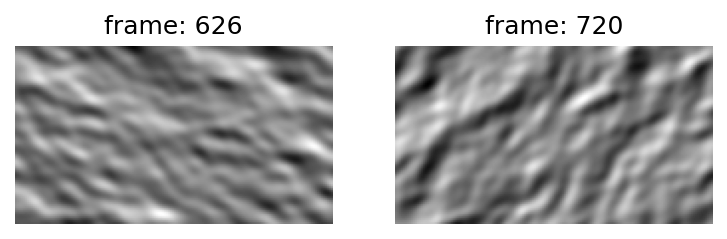

In [51]:
fig, axs = plt.subplots(1, 2, dpi=150) # view first and last frame of movie slice
axs[0].imshow(stimulus_trial_slice[:,:,0], cmap='gray')
axs[0].set_title(f'frame: {start}')
axs[1].imshow(stimulus_trial_slice[:,:,-1], cmap='gray')
axs[1].set_title(f'frame: {end}')
[ax.axis('off') for ax in axs];

### Stimulus from AWS bucket 

The stimuli presented above are temporarily downsampled and aligned to the functional recording as convienient ways to represent stimulus and activity in the same index.  However, the actual stimulus shown to the animal was presented at 30Hz, with the first frame starting at time=0. The complete 30Hz stimulus shown during each scan can be downloaded from an AWS bucket.

In [52]:
import requests
import skvideo.io

In [53]:
base_url = 'https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/functional_data/stimulus_movies'

In [54]:
filename = f'stimulus_17797_{scan_key["session"]}_{scan_key["scan_idx"]}_v1.avi'

In [55]:
url = base_url + '/' + filename
url

'https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/functional_data/stimulus_movies/stimulus_17797_4_7_v1.avi'

Uncomment the below cell to download movie. Each movie is approx 2GB movie. This will write the stimulus to the current directory as an avi. 

In [56]:
# movie_aws = requests.get(url) 

# with open(filename, 'wb') as f:
#     f.write(movie_aws.content) 

### Summary image

A summary image of the field can be found in `nda.SummaryImages`. 

There are two types of images available, `correlation` and `average`. Details of how these are computed can be found in the accompanying methods.

In [57]:
nda.SummaryImages & field_key

session Session ID,scan_idx Scan ID,field Field Number,correlation correlation image,average average image
4,7,4,=BLOB=,=BLOB=


#### Fetch and view images

In [58]:
corr, avg = (nda.SummaryImages & field_key).fetch1('correlation', 'average')

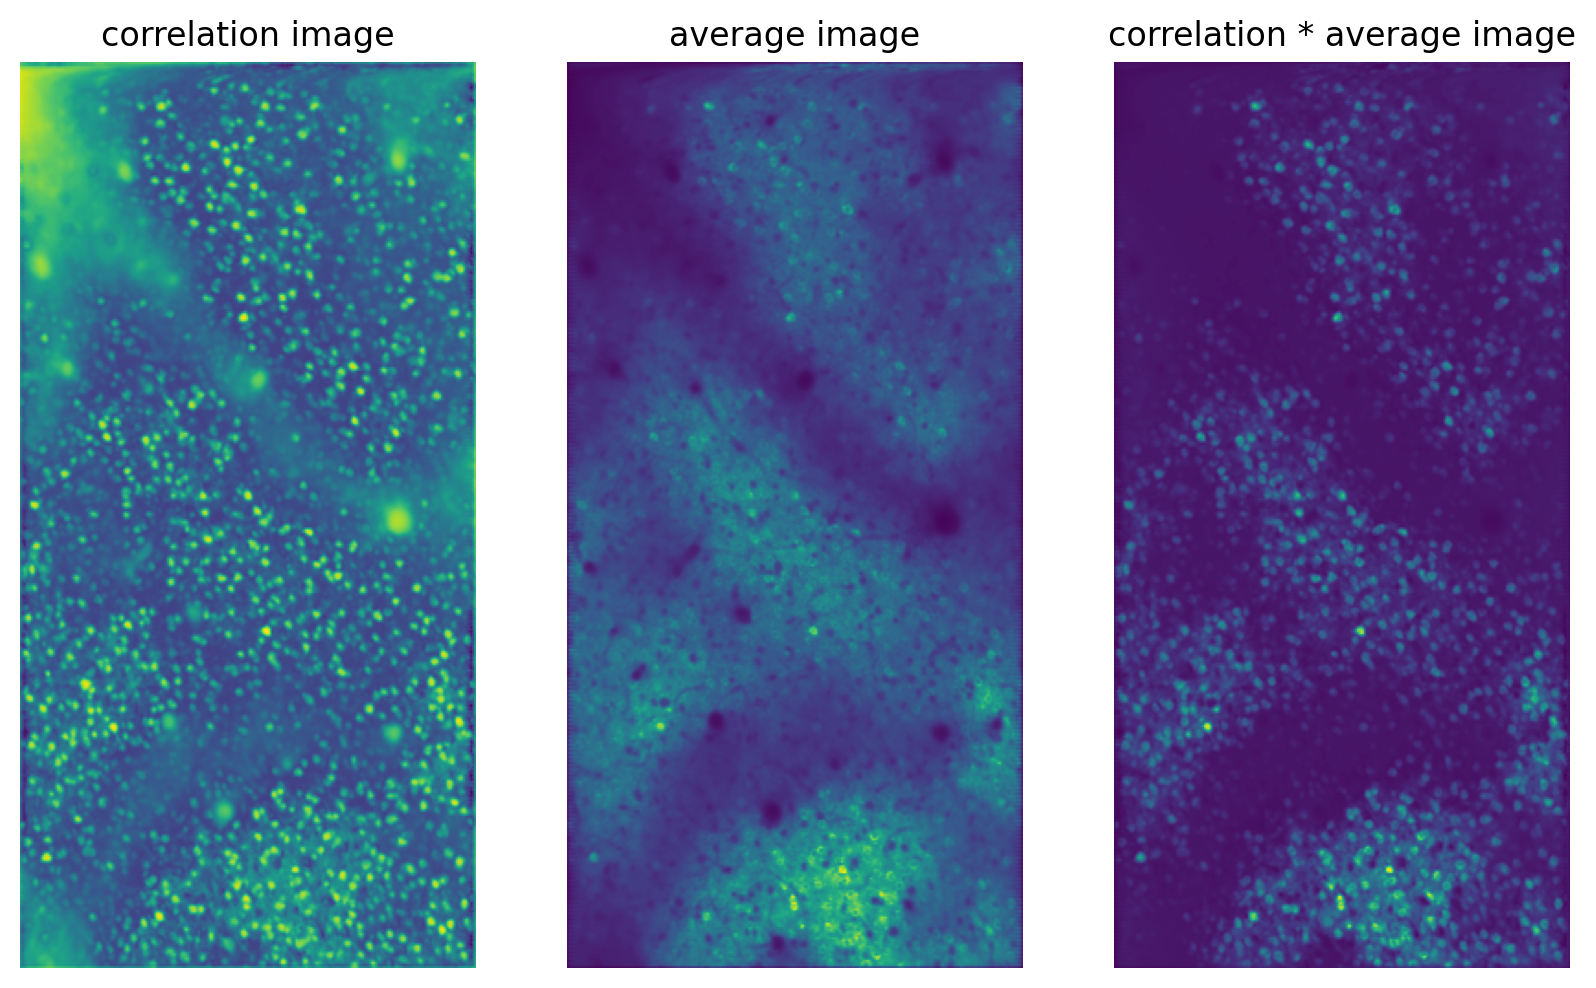

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(10,6), dpi=200)
axs[0].imshow(corr)
axs[0].set_title('correlation image')
axs[1].imshow(avg)
axs[1].set_title('average image')
axs[2].imshow(corr*avg) # gives a good view of the cell bodies and darkens vessels
axs[2].set_title('correlation * average image')
[ax.axis('off') for ax in axs];
[ax.set_aspect('auto') for ax in axs];

### Masks

The functional ROI segmentation gives a set of 2D masks indexed by `mask_id`, which are unique per `field`. A cell that was scanned in more than one imaging field will have more than one mask. Masks are stored in `nda.Segmentation`. Classification of masks as `soma` or `artifact` is stored in `nda.MaskClassification`. See technical documentation for further details on segmentation and classification methods.

In [62]:
nda.Segmentation * nda.MaskClassification & field_key

session Session ID,scan_idx Scan ID,field Field Number,mask_id,pixels indices into the image in column major (Fortran) order,weights weights of the mask at the indices above,mask_type classification of mask as soma or artifact
4,7,4,1,=BLOB=,=BLOB=,artifact
4,7,4,2,=BLOB=,=BLOB=,soma
4,7,4,3,=BLOB=,=BLOB=,soma
4,7,4,4,=BLOB=,=BLOB=,artifact
4,7,4,5,=BLOB=,=BLOB=,soma
4,7,4,6,=BLOB=,=BLOB=,soma
4,7,4,7,=BLOB=,=BLOB=,soma
4,7,4,8,=BLOB=,=BLOB=,soma
4,7,4,9,=BLOB=,=BLOB=,artifact
4,7,4,10,=BLOB=,=BLOB=,artifact


Fetch masks and plot over the summary image to view them. 

*Note: the image below is intended to show the density and location of masks, but to better visualize the shape and weights of individual masks, plot them one at a time. *

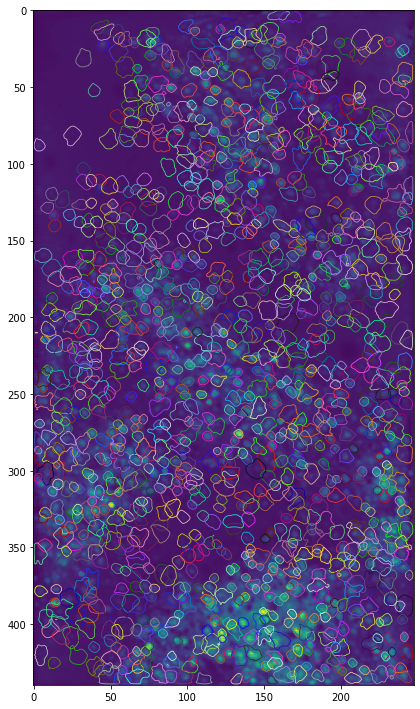

In [63]:
# function that will retrieve masks in convenient format and optionally plot
masks = func.get_all_masks(field_key, mask_type='soma', plot=True) 

### Calcium fluorescence traces

Each mask has a GCaMP6 fluorescence trace in `nda.Fluorescence`.

In [64]:
calcium_trace = (nda.Fluorescence() & field_key & {'mask_id': 500}).fetch1('trace')

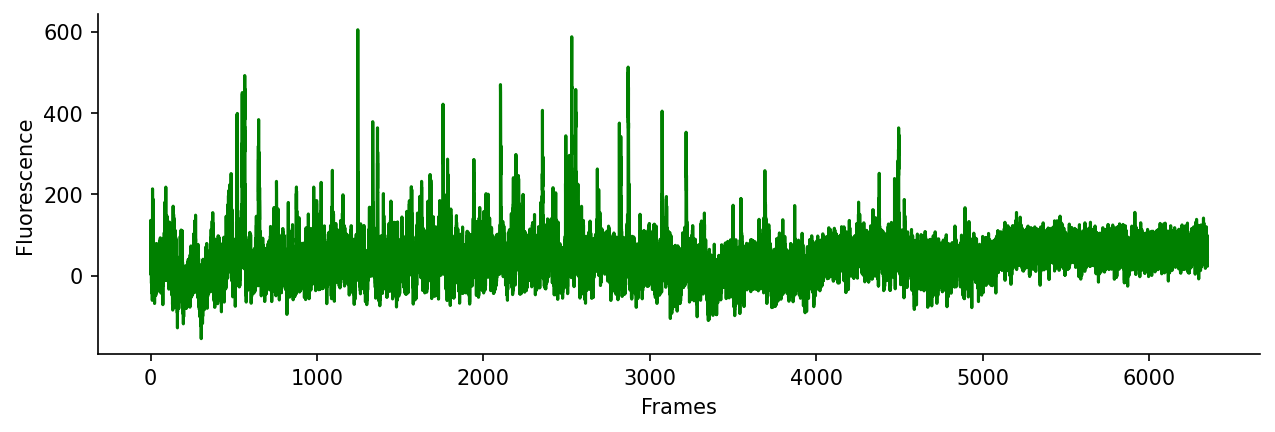

In [65]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(frame_times, calcium_trace, c='g')
ax.set_xlabel('Frames')
ax.set_ylabel('Fluorescence')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

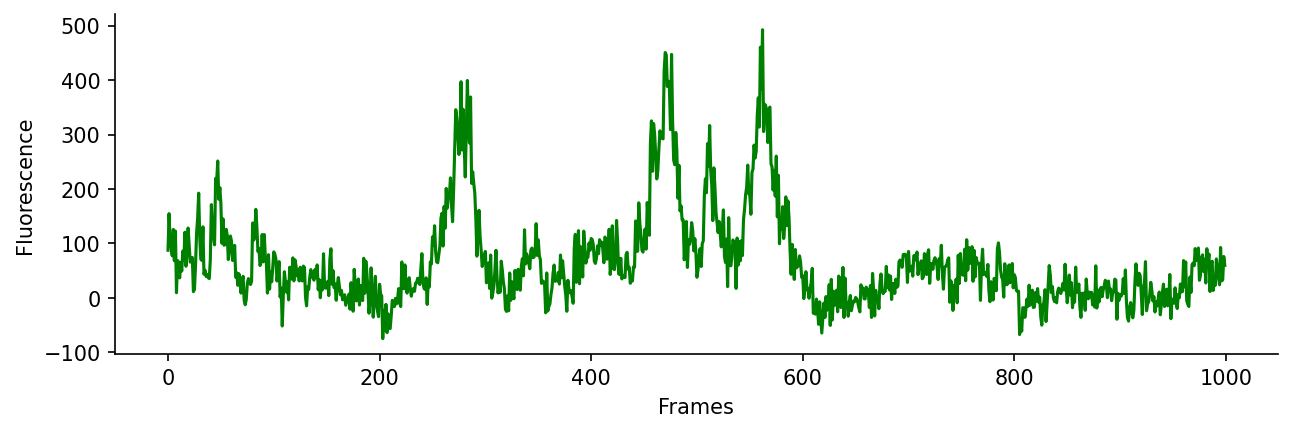

In [12]:
# lets zoom in on one portion to see some transients
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(frame_times[3000:4000], calcium_trace[3000:4000], c='g')
ax.set_xlabel('Frames')
ax.set_ylabel('Fluorescence')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Single unit information

For the purposes of this schema, a `unit` is a re-indexing of all masks across all imaging fields of a scan and indexed by `unit_id`. `unit_id` is unique per scan.

Note: `unit_id` is not a consolidation step, only re-indexing. Therefore, if a cell was scanned in multiple imaging fields within the scan, just as it had multiple `mask_id's`, it will also have multiple `unit_id's`. 

Information for all units in the scan can be found in `nda.ScanUnit`. This table can be used to relate `mask_id` to its `unit_id`.  

In [54]:
# unit coordinates (`um_x`, `um_y`, `um_z`) are in microns and in the original motor reference frame (see technical documentation for more info)
# unit coordinate (`px_x` and `px_y` are the unit coordinates in image pixels)
# this table can also be used to relate `unit_id's` and `mask_id's` that are used in nda.Segmentation and nda.Fluorescence
nda.ScanUnit() & scan_key

session Session ID,scan_idx Scan ID,unit_id unique per scan,field Field Number,mask_id mask id unique per field,um_x centroid x motor coordinates (microns),um_y centroid y motor coordinates (microns),um_z centroid z motor coordinates (microns),px_x centroid x pixel coordinate in field (pixels),px_y centroid y pixel coordinate in field (pixels),ms_delay delay from start of frame (field 1 pixel 1) to recording of this unit (milliseconds)
4,7,1,1,1,-778,-771,80,7,5,0
4,7,2,1,2,-741,-766,80,22,7,0
4,7,3,1,3,-691,-776,80,41,3,0
4,7,4,1,4,-691,-766,80,42,8,0
4,7,5,1,5,-702,-767,80,37,7,0
4,7,6,1,6,-646,-764,80,60,8,0
4,7,7,1,7,-553,-770,80,97,6,0
4,7,8,1,8,-534,-758,80,105,11,0
4,7,9,1,9,-499,-760,80,119,10,0
4,7,10,1,10,-460,-768,80,134,7,0


### Oracle score 

The oracle score is a leave-one-out correlation for repeated segments of stimulus. It provides an estimate of visual response reliability for a given unit over the course of the scan. For more detail see the technical documentation found [here](https://www.microns-explorer.org/cortical-mm3#f-data).

Oracle scores are found in `nda.Oracle`. 

*Note that only masks classified as "soma" in `nda.MaskClassification` currently have oracle scores computed. This may change in a future version.*

In [55]:
oracles = (nda.Oracle & scan_key).fetch('pearson')

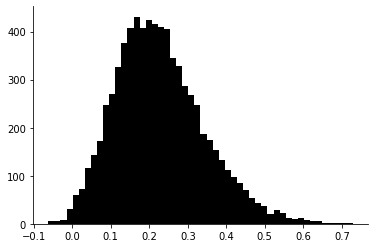

In [56]:
fig, ax = plt.subplots()
ax.hist(oracles, bins=50, color='k');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [57]:
high_oracle_percentile = np.percentile(oracles, 99)

Oracle scores greater than a threshold value can be specified by restricting the table with a string: `'pearson>x'` where `x` is the oracle value threshold.

In [58]:
high_oracle_table = nda.Oracle & scan_key & f'pearson>{high_oracle_percentile}'
high_oracle_table

session Session ID,scan_idx Scan ID,unit_id unique per scan,trials number of trials used,pearson per unit oracle pearson correlation over all movies
4,7,130,60,0.623745
4,7,327,60,0.61131
4,7,493,60,0.54457
4,7,688,60,0.561252
4,7,756,60,0.617953
4,7,775,60,0.638734
4,7,795,60,0.613519
4,7,907,60,0.574646
4,7,1070,60,0.553697
4,7,1177,60,0.57389


Select the nth entry in the table by passing an `offset` and `limit` to the `fetch` method.

In [59]:
unit_key = high_oracle_table.fetch('KEY', offset=10, limit=1)[0]
unit_key

{'session': 4, 'scan_idx': 7, 'unit_id': 1262}

### Plot oracle raster

The function `fetch_oracle_raster` provided in the `func` module retrieves the responses for the functional unit for the repeated stimulus trials (oracle trials).

In [60]:
oracle_traces, score = func.fetch_oracle_raster(unit_key)

Text(0.5, 1.2, 'session: 4, scan_idx: 7, unit_id: 1262')

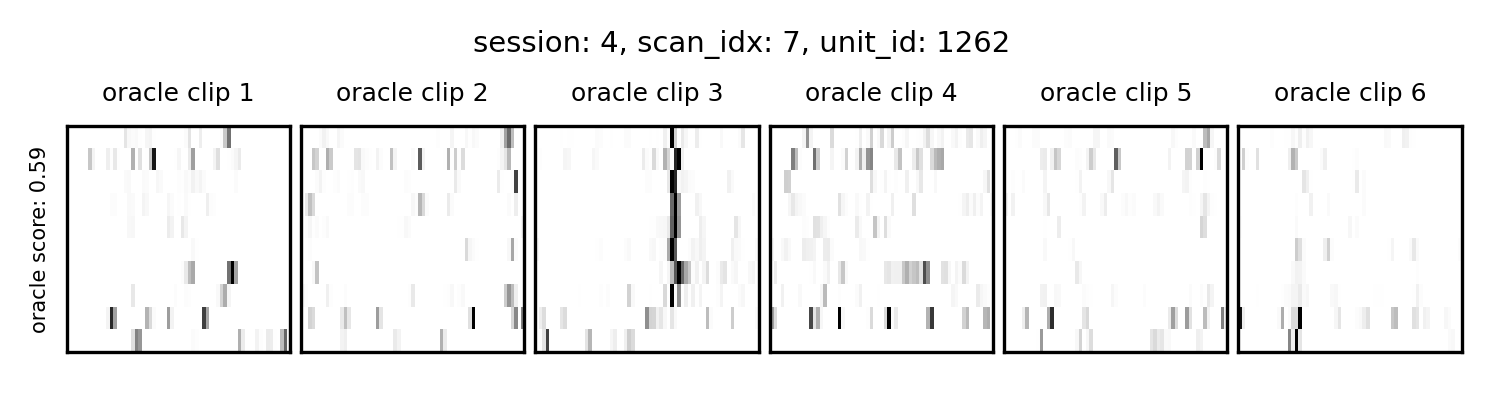

In [61]:
fig,axes = plt.subplots(1,6, figsize=(6,1),dpi=300)
for col,clip_trace in zip(axes,np.moveaxis(oracle_traces,1,0)):
    col.imshow(clip_trace,cmap='binary', interpolation='nearest')
    col.set_aspect('auto')
    col.set_xticks([])
    col.set_yticks([])
axes[0].set_ylabel(f'oracle score: {score:.2f}', fontsize=5)
fig.subplots_adjust(wspace=.05)
[ax.set_title(f'oracle clip {i+1}', fontsize=6) for i, ax in enumerate(axes)];
fig.suptitle(f'session: {unit_key["session"]}, scan_idx: {unit_key["scan_idx"]}, unit_id: {unit_key["unit_id"]}', fontsize=7, y=1.2)

### Spike traces

Spike traces are in `nda.Activity` and associated with single units (`unit_id's`).

In [63]:
nda.Activity() & unit_key

session Session ID,scan_idx Scan ID,unit_id unique per scan,trace spike trace
4,7,1262,=BLOB=


In [64]:
spike_trace = (nda.Activity() & unit_key).fetch1('trace')

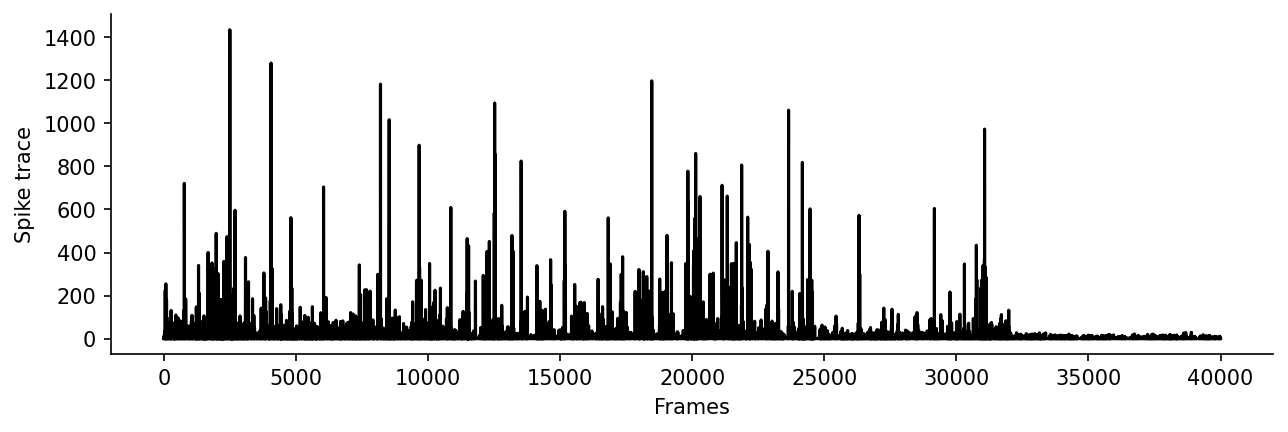

In [65]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(spike_trace, c='k')
ax.set_xlabel('Frames')
ax.set_ylabel('Spike trace')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### View  fluorescence trace, and spike trace for the same unit

Use `nda.ScanUnit` to bridge between `unit_id` and `mask_id` to plot both the calcium trace spike trace and for a single unit.

In [66]:
nda.Fluorescence & (nda.ScanUnit & unit_key)

session Session ID,scan_idx Scan ID,field Field Number,"mask_id mask ID, unique per field",trace fluorescence trace
4,7,3,167,=BLOB=


In [67]:
calcium_trace = (nda.Fluorescence & (nda.ScanUnit & unit_key)).fetch1('trace')

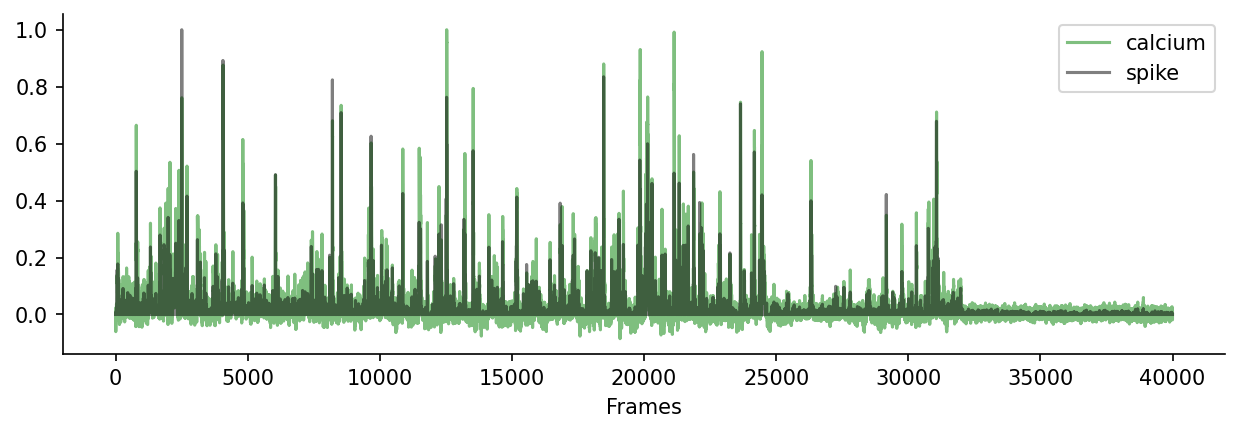

In [68]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(calcium_trace/ np.max(calcium_trace), c='g', alpha=0.5, label='calcium')
ax.plot(spike_trace/ np.max(spike_trace), c='k', label='spike', alpha=0.5)
ax.set_xlabel('Frames')
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Mean Intensity

The mean intensity of the calcium signal for the entire field is computed per frame for the duration of the scan. This is found in `nda.MeanIntensity`. Periods of low intensity may indicate a low quality stretch of scan, for example where water might have temporarily run out between the microscope objective and imaging site.

In [60]:
intensities = (nda.MeanIntensity & field_key).fetch1('intensities')

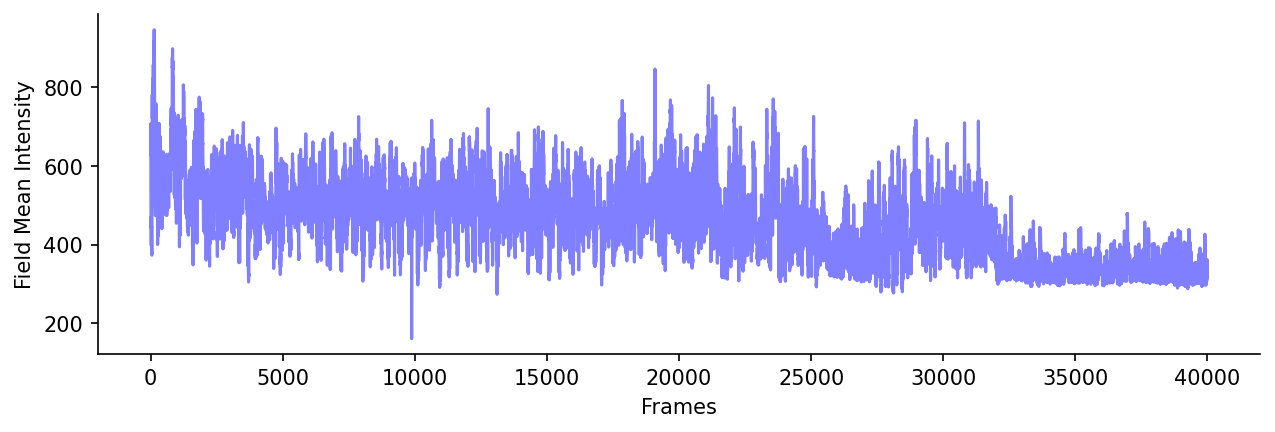

In [61]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(intensities, c='b', alpha=0.5)
ax.set_xlabel('Frames')
ax.set_ylabel('Field Mean Intensity')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Behavior
### Pupil

The pupil radius for each scan is found in `nda.RawManualPupil` and `nda.ManualPupil`. 

`pupil_min_r` is the smaller of the two radii from the ellipse fit to the pupil and `pupil_maj_r` is the larger radius. 

The tracked position of the pupil is found in `pupil_x` and `pupil_y`. 

`nda.RawManualPupil` contains the pupil traces and `pupil_times` at the original acquisition rate.

`nda.ManualPupil` contains the pupil traces synced to the `field 1` scan times (found in the `field1_times` attribute in `nda.DepthTimes`)



In [41]:
nda.RawManualPupil() & scan_key

session Session ID,scan_idx Scan ID,pupil_min_r vector of pupil minor radii synchronized with field 1 frame times (pixels),pupil_maj_r vector of pupil major radii synchronized with field 1 frame times (pixels),pupil_x vector of pupil x positions synchronized with field 1 frame times (pixels),pupil_y vector of pupil y positions synchronized with field 1 frame times (pixels),pupil_times vector of timestamps relative to scan start (seconds)
4,7,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [42]:
nda.ManualPupil & scan_key

session Session ID,scan_idx Scan ID,pupil_min_r vector of pupil minor radii synchronized with field 1 frame times (pixels),pupil_maj_r vector of pupil major radii synchronized with field 1 frame times (pixels),pupil_x vector of pupil x positions synchronized with field 1 frame times (pixels),pupil_y vector of pupil y positions synchronized with field 1 frame times (pixels)
4,7,=BLOB=,=BLOB=,=BLOB=,=BLOB=


### Treadmill

The treadmill velocity for each scan is found in `nda.RawTreadmill` and `nda.Treadmill`.

`nda.RawTreadmill` contains the treadmill velocity trace and timestamps at the original acquisition rate.

`nda.Treadmill` contains the treadmill velocity trace synced to the `field 1` scan times (found in the `field1_times` attribute in `nda.DepthTimes`)

In [43]:
nda.RawTreadmill & scan_key

session Session ID,scan_idx Scan ID,treadmill_velocity vector of treadmill velocities (cm/s),treadmill_timestamps vector of times relative to scan start (seconds)
4,7,=BLOB=,=BLOB=


In [44]:
nda.Treadmill & scan_key

session Session ID,scan_idx Scan ID,treadmill_velocity vector of treadmill velocities synchronized with field 1 frame times (cm/s)
4,7,=BLOB=


## Visualize area labels in 2P stack space

### Area membership

Computed area membership labels are found in `nda.AreaMembership`.

View area labels for units in 2D space (x, y) in `stack` reference frame.

In [62]:
nda.AreaMembership()

session Session ID,scan_idx Scan ID,unit_id unique per scan,brain_area Visual area membership of unit
4,7,1,LM
4,7,2,LM
4,7,3,LM
4,7,4,LM
4,7,5,LM
4,7,6,LM
4,7,7,LM
4,7,8,LM
4,7,9,LM
4,7,10,LM


Let's pull out the area membership of every stack unit, and use it to color a scatter plot

In [90]:
area, x, y = (nda.AreaMembership * nda.StackUnit).fetch('brain_area', 'stack_x', 'stack_y')

In [91]:
color_dict = {'LM':'blue', 'AL': 'green', 'RL': 'purple', 'V1': 'red'}

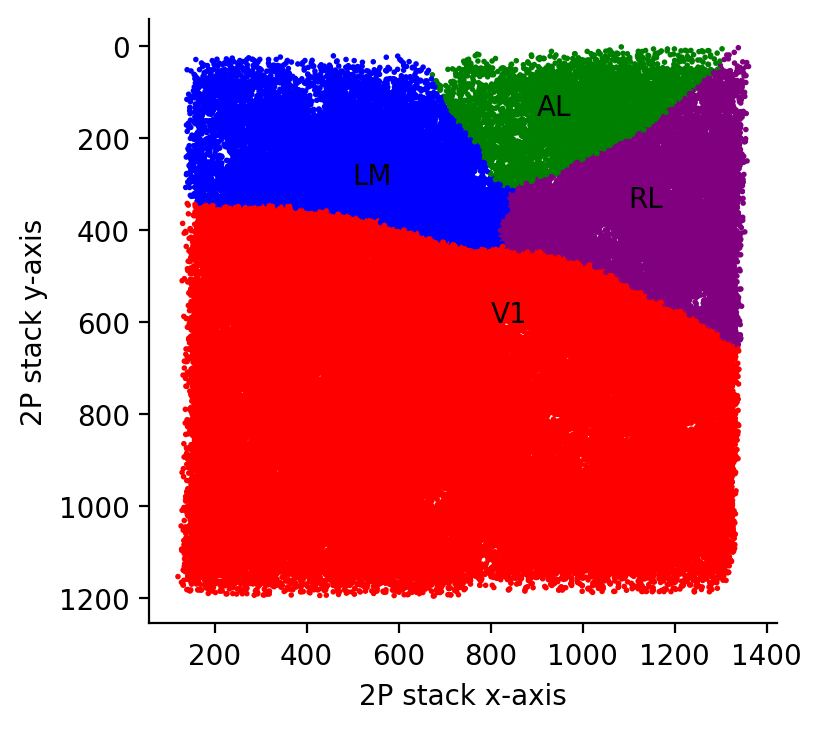

In [92]:
fig, ax = plt.subplots(dpi=200)
ax.scatter(x, y, color=[color_dict[a] for a in area], s=1)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_xlabel('2P stack x-axis')
ax.set_ylabel('2P stack y-axis')
ax.annotate('LM', (500, 300))
ax.annotate('AL', (900, 150))
ax.annotate('RL', (1100, 350))
ax.annotate('V1', (800, 600))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)